# Caracterization

This notebook contains analysis on the graph of Movie Lens 1M dataset. We consider this dataset to be a directed bipartite graph where nodes are users and items, with edges going from users to items and the edge-weights being the users' ratings. 

In [2]:
import os, sys
import networkx as nx
from powerlaw import ccdf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import time
import utils

In [3]:
config_file = './config_file.json'
params = utils.Params(config_file)
data_folder = os.path.join('..', 'Data', params.dataset)
images_folder = os.path.join('.', 'Images')
variables_folder = os.path.join('.', 'Variables')

## Loading the Dataset

In [4]:
dataset_tag, dataset_file = params.dataset, os.path.join(data_folder, 'ratings.dat')
df = pd.read_csv(dataset_file, header=None, sep=r'::', engine="python")
df.columns = ["from", "to", "rating", "timestamp"]
df['from'] = df['from'].apply(lambda x: 'user_' + str(x))
df['to'] = df['to'].apply(lambda x: 'item_' + str(x))
# My job starts here ! ;D
# df.drop(["timestamp"], axis=1, inplace=True)
df.to_csv(os.path.join(variables_folder, dataset_tag + "_edgelist.txt"), sep='\t', index=False, header=None)
df.tail()

,from,to,rating,timestamp
1000204,user_6040,item_1091,1,956716541
1000205,user_6040,item_1094,5,956704887
1000206,user_6040,item_562,5,956704746
1000207,user_6040,item_1096,4,956715648
1000208,user_6040,item_1097,4,956715569


## Processing Time

In [ ]:
time_sorted = df.sort_values(by=['timestamp'], ascending=False)
print('Max time: ', 
          time.strftime("%D %H:%M", time.localtime(int(time_sorted['timestamp'].max()))), 
      'and Min time: ', 
          time.strftime("%D %H:%M", time.localtime(int(time_sorted['timestamp'].min()))) )

In [ ]:
time_sorted['datetime'] = pd.to_datetime(time_sorted['timestamp'].astype(int), unit='s')
time_sorted_index = time_sorted.set_index(pd.DatetimeIndex(time_sorted['datetime']))

In [ ]:
time_sorted_index[(time_sorted_index['datetime'] > '2003-02-27')].head()

### Splitting by Time

In [ ]:
# Define a type : year ; month ; week ; day ( would be nice to only see weekends jão ? ) 
# And split your dataset evenly by that amount
## Fun fact: There are somedays that have WAY more data than some. this WILL impact the prediction. Maybe normalize the rating. for example.
def dataset_time_splitter(param_timedf, splitting_strategy = None):
    if param_timedf is None or splitting_strategy is None:
        return
    
    # Year 2003 is just 2 months so ignored it.
    if splitting_strategy == "year":
        df_time_return_1 = param_timedf[param_timedf.index.year.isin([2002,2003])]
        df_time_return_2 = param_timedf[param_timedf.index.year.isin([2001])]
        df_time_return_3 = param_timedf[param_timedf.index.year.isin([2000])]
        return [df_time_return_1, df_time_return_2 , df_time_return_3]
    if splitting_strategy == "month":
        lista_dfs_months = []
        for x in range(1, 13):
            lista_dfs_months.append(param_timedf[param_timedf.index.month.isin([x])])
        return lista_dfs_months
    # around 50 weeks each year, total of 156
    if splitting_strategy == "week":
        lista_dfs_weeks  = []
        for y in range (2000, 2003):
            for x in range(1, (max(time_sorted_index.index.week)+1)):
                lista_dfs_weeks.append(param_timedf[param_timedf.index.week.isin([x]) & param_timedf.index.year.isin([y])])
        return lista_dfs_weeks
    # around 365 weeks each year, total of 1096
    if splitting_strategy == "day":
        lista_dfs_days  = []
        for y in range (2000, 2003):
            for x in range(1, (max(time_sorted_index[time_sorted_index.index.year.isin([y])].index.dayofyear)+1)):
                lista_dfs_days.append(param_timedf[param_timedf.index.dayofyear.isin([x]) & param_timedf.index.year.isin([y])])
        return lista_dfs_days

In [ ]:
lista = dataset_time_splitter(time_sorted_index,"year")

In [ ]:
len(lista)

## Creating Network

In [ ]:
def build_list_of_networks(param_list):
    graph_list = []
    G = nx.DiGraph()
    for df_graph in param_list:
        for user_id in df_graph["from"].unique():
            G.add_node(user_id, node_type="user")
        for item_id in df_graph["to"].unique():
            G.add_node(item_id, node_type="item")
        G.add_weighted_edges_from(df_graph[["from", "to", "rating"]].values)
        graph_list.append(G)
    return graph_list

In [ ]:
graph_list = build_list_of_networks(lista)

In [ ]:
def print_specs_for_graphs(param_list_graph):
    for G in param_list_graph:
        print("*****************************************")
        print ("Number of edges: ", G.number_of_edges())
        print ("Number of nodes: ", G.number_of_nodes())
#         for node_type in ["user", "item"]:
#             n_type_nodes = G.subgraph([n for n,attrdict in G.node.items() if attrdict['node_type'] == node_type] ).number_of_nodes()
#             print ("Number of " + node_type + " nodes: ", n_type_nodes)
        print ("Is strongly connected: ", nx.is_strongly_connected(G))
        print ("Number of strongly connected components: ", nx.number_strongly_connected_components(G))
        print("*****************************************")

In [ ]:
print_specs_for_graphs(graph_list)

In [ ]:
## Proximos passos : Adicionar mais estatisticas e observar a variacao no ano.

## Getting Statistics
### Degree

In [5]:
G = nx.DiGraph()
for user_id in df["from"].unique():
    G.add_node(user_id, node_type="user")
for item_id in df["to"].unique():
    G.add_node(item_id, node_type="item")
G.add_weighted_edges_from(df[["from", "to", "rating"]].values)

In [6]:
df_stats = pd.DataFrame(nx.degree(G))
df_stats.columns = ['node', 'degree']
df_stats['degree_centrality'] = nx.degree_centrality(G).values()
# dict_metrics[dataset_tag]["degree"] = np.array(df_stats["degree"])
df_stats.tail()

,node,degree,degree_centrality
9741,item_2198,2,0.000205
9742,item_2703,1,0.000103
9743,item_2845,1,0.000103
9744,item_3607,1,0.000103
9745,item_2909,1,0.000103


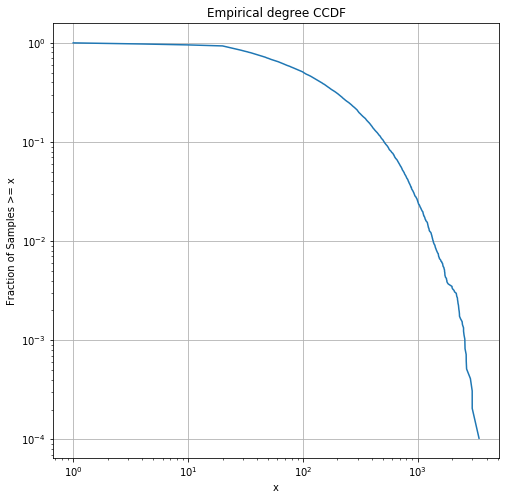

In [7]:
def plot_ccdf(samples, name=''):
    x, y = ccdf(samples)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.set_title("Empirical " + name + " CCDF")
    ax.plot(x, y)
    ax.set_xscale("log"), ax.set_yscale("log")
    ax.set_xlabel("x"), ax.set_ylabel("Fraction of Samples >= x")
    ax.grid(True)
    return fig, ax 

fig, ax = plot_ccdf(df_stats["degree"], "degree")
fig.savefig(os.path.join('.', 'Images', 'empirical_degree_ccdf.jpg'), bbox_inches='tight')

## Saving degree to trainable dataset

In [8]:
df_degrees = pd.merge(df, df_stats, how='inner', left_on='from', right_on='node').drop(['node'], axis=1)
df_degrees = pd.merge(df_degrees, df_stats, how='inner', left_on='to', right_on='node', 
                   suffixes=['_user', '_item']).drop(['node'], axis=1)
df_degrees

,from,to,rating,timestamp,degree_user,degree_centrality_user,degree_item,degree_centrality_item
0,user_1,item_1193,5,978300760,53,0.005439,1725,0.177014
1,user_2,item_1193,5,978298413,129,0.013238,1725,0.177014
2,user_12,item_1193,4,978220179,23,0.002360,1725,0.177014
3,user_15,item_1193,4,978199279,201,0.020626,1725,0.177014
4,user_17,item_1193,5,978158471,211,0.021652,1725,0.177014
...,...,...,...,...,...,...,...,...
1000204,user_5949,item_2198,5,958846401,181,0.018574,2,0.000205
1000205,user_5675,item_2703,3,976029116,586,0.060133,1,0.000103
1000206,user_5780,item_2845,1,958153068,259,0.026578,1,0.000103
1000207,user_5851,item_3607,5,957756608,162,0.016624,1,0.000103


In [9]:
df_degrees.to_csv(os.path.join(variables_folder, 'df_degrees.csv'), sep=';', index=None)

## Studying Threshold Variations

How the number of users or items vary when we make degree centrality thresholds ?

In [11]:
# Sets an array with the applied thresholds to be made
step_size = 30
degree_thr = np.array([float(x)/100.0 for x in np.logspace(-2, 2, step_size, dtype=float)])
# degree_thr = [1e-2, 2e-2, 4e-2, 6e-2, 8e-2, 1e-1, 2e-1, 3e-1]
degree_thr

array([1.00000000e-04, 1.37382380e-04, 1.88739182e-04, 2.59294380e-04,
       3.56224789e-04, 4.89390092e-04, 6.72335754e-04, 9.23670857e-04,
       1.26896100e-03, 1.74332882e-03, 2.39502662e-03, 3.29034456e-03,
       4.52035366e-03, 6.21016942e-03, 8.53167852e-03, 1.17210230e-02,
       1.61026203e-02, 2.21221629e-02, 3.03919538e-02, 4.17531894e-02,
       5.73615251e-02, 7.88046282e-02, 1.08263673e-01, 1.48735211e-01,
       2.04335972e-01, 2.80721620e-01, 3.85662042e-01, 5.29831691e-01,
       7.27895384e-01, 1.00000000e+00])

### Getting Threshold Variations

We have 2 strategies here: 

- `upper`: only users/items with **higher** degree centrality than the threshold are allowed in the results dataset
- `lower`: only users/items with **lower** degree centrality than the threshold are allowed in the results dataset 

In [12]:
%%time
n_users_thr, n_items_thr = [], []
user_degree_thr, item_degree_thr = [], []
n_users_max = len(df_degrees['from'].unique())
n_items_max = len(df_degrees['to'].unique())
strategy = 'upper_degree_centrality' # upper, lower
for threshold in degree_thr:    
    if strategy == 'upper_degree_centrality':
        df_temp = df_degrees[df_degrees['degree_centrality_user'] > threshold]
    else:
        df_temp = df_degrees[df_degrees['degree_centrality_user'] < threshold]        
    n_users = len(df_temp['from'].unique())    
    n_users_thr.append(n_users)
    user_degree_thr.append(threshold)
    if n_users == 0 and strategy == 'upper_degree_centrality':
        break
    if n_users == n_users_max and strategy == 'lower_degree_centrality':
        break  
        
for threshold in degree_thr:    
    if strategy == 'upper_degree_centrality':
        df_temp = df_degrees[df_degrees['degree_centrality_item'] > threshold]
    else:
        df_temp = df_degrees[df_degrees['degree_centrality_item'] < threshold]        
    n_items = len(df_temp['to'].unique())    
    n_items_thr.append(n_items)
    item_degree_thr.append(threshold)
    if n_items == 0 and strategy == 'upper_degree_centrality':
        break
    if n_items == n_items_max and strategy == 'lower_degree_centrality':
        break  
        
df_temp.head()

Wall time: 11.8 s


In [13]:
arr = []
for u, u_thr in enumerate(user_degree_thr):
    for i, i_thr in enumerate(item_degree_thr):
        arr.append([u_thr, n_users_thr[u], i_thr, n_items_thr[i]])
df_exp = pd.DataFrame(arr, columns=['degree_centrality_users', 'n_users', 'degree_centrality_items', 'n_items'])
cond1 = df_exp['n_users'] > 5
cond2 = df_exp['n_items'] > 5
df_exp = df_exp[cond1 & cond2]
df_exp.to_csv(os.path.join(variables_folder, 'df_exp.csv'), sep=';', index=None)
df_exp

,degree_centrality_users,n_users,degree_centrality_items,n_items
0,0.000100,6040,0.000100,3706
1,0.000100,6040,0.000137,3592
2,0.000100,6040,0.000189,3592
3,0.000100,6040,0.000259,3503
4,0.000100,6040,0.000356,3461
...,...,...,...,...
641,0.148735,6,0.057362,549
642,0.148735,6,0.078805,339
643,0.148735,6,0.108264,185
644,0.148735,6,0.148735,74


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

df_plot = pd.DataFrame(df_exp.groupby(['degree_centrality_users'])['n_users'].max()).reset_index(drop=False)
axes[0].axhline(df_plot['n_users'].max(), color='r')
axes[0].plot(df_plot['degree_centrality_users'], df_plot['n_users'])
axes[0].set_title('Number of Users x Degree Centrality Threshold')
axes[0].set_xscale('log')

df_plot = pd.DataFrame(df_exp.groupby(['degree_centrality_items'])['n_items'].max()).reset_index(drop=False)
axes[1].axhline(df_plot['n_items'].max(), color='r')
axes[1].plot(df_plot['degree_centrality_items'], df_plot['n_items'])
axes[1].set_title('Number of Items x Degree Centrality Threshold')
axes[1].set_xscale('log')

[ax.grid(True) for ax in axes]
[ax.set_xlabel('Degree Centrality Threshold') for ax in axes]
[ax.set_ylabel('Quantity') for ax in axes]
fig.savefig(os.path.join('.', 'Images', strategy + '_quantity_vs_degree_centrality_thr.jpg'), bbox_inches='tight')